Author: Paulina Pojda

**1. advection PDE**

Let's introduce a few symbols:   
* ${\color{red}t}$: time   
* ${\color{blue}x}$: physical coordinate (e.g., distance or altitude)   
* ${\color{green}\psi}({\color{blue}x})$: scalar field (e.g., pollutant concentration)   
* ${\color{brown}u}$: carrier velocity field (e.g., wind)   

Transport of $\color{green}\psi$ due to advection by $\color{brown}u$ can be modelled with the advection equation:
$$ \partial_{\color{red} t} {\color{green}\psi} + \partial_{\color{blue}x} \left({\color{brown}u} {\color{green}\psi}\right) = 0 $$

For the special case of $\partial_{\color{blue}x} {\color{brown}u}=0$, an analytical solution describing translation of the signal is readily available:
$$ {\color{green}\psi}({\color{blue}x}, {\color{red}t})=\psi_0({\color{blue}x} - {\color{brown}u}{\color{red}t})$$
where $\psi_0({\color{blue}x})={\color{green}\psi}({\color{blue}x}, 0)$. 

Let's depict the problem using NumPy and matplotlib:

In [1]:
import numpy as np
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from open_atmos_jupyter_utils import show_plot

In [2]:
class Psi_0:
    def __init__(self):
        self.x0 = 5
        self.a = 1
        self.sigma = 25
    def __call__(self, x):
        return self.a * np.exp(-(x-self.x0)**2 / 2 / self.sigma**2)

In [3]:
psi_0 = Psi_0()
nx = 64
x, dx = np.linspace(-100, 300, nx, endpoint=False, retstep=True)
u = 2
t_max = 50
print(x)

[-100.    -93.75  -87.5   -81.25  -75.    -68.75  -62.5   -56.25  -50.
  -43.75  -37.5   -31.25  -25.    -18.75  -12.5    -6.25    0.      6.25
   12.5    18.75   25.     31.25   37.5    43.75   50.     56.25   62.5
   68.75   75.     81.25   87.5    93.75  100.    106.25  112.5   118.75
  125.    131.25  137.5   143.75  150.    156.25  162.5   168.75  175.
  181.25  187.5   193.75  200.    206.25  212.5   218.75  225.    231.25
  237.5   243.75  250.    256.25  262.5   268.75  275.    281.25  287.5
  293.75]


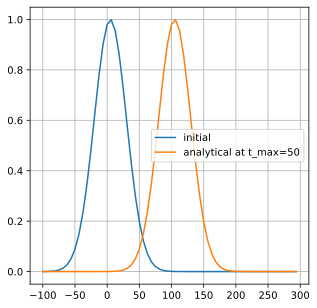

In [4]:
fig = pyplot.figure(figsize=(5,5))
pyplot.plot(x, psi_0(x), label='initial')
pyplot.plot(x, psi_0(x - u * t_max), label=f'analytical at {t_max=}')
pyplot.legend()
pyplot.grid()
show_plot(fig=fig)

**2. overview of applications**

* **computational fluid dynamics**: Navier-Stokes momentum equation ($\psi$: fluid momentum)
* **fluid thermodynamics**: energy conservation ($\psi$: thermal energy)
* **atmospheric modelling incl. weather prediction**: mass conservation ($\psi$: humidity, rain, pollutants, ...)
* **derivative pricing in financial mathematics**: Black-Scholes equation ($\psi$: discounted value of a derivative instrument)
* ...

**3. simple numerical solution using the "upwind" scheme coded in Python**

For cases where the velocity varies in space (and for many other more complex cases), numerical integration is the only way of solving the advection PDE. Among numerous numerical schemes for solving it, let's look at the basic [**upwind**](https://en.wikipedia.org/wiki/Upwind_scheme) solver: 

Let's consider the following discretisation of the problem:   
* ${\color{red}n} = \frac{\color{red}t}{\Delta t} \in 0, 1, \ldots$   
* ${\color{blue}i} = \frac{\color{blue}x}{\Delta x} \in 0, 1, \ldots$   
* ${\color{brown}C} = {\color{brown}u}\frac{\Delta t}{\Delta x}$ (so called Courant number)   
* ${\color{green}\psi}_{\color{blue}i}^{\color{red}n}$: scalar field at "grid cell" $\color{blue}i$ in space at time "level" ${\color{red}n}$   

The explicit (forward-in-time) upwind scheme is defined as:
$$
  {\color{green}\psi}^{{\color{red}n}+1}_{\color{blue}i} = {\color{green}\psi}^{\color{red}n}_{\color{blue}i} - \left[F\left({\color{green}\psi}^{\color{red}n}_{\color{blue}i},  {\color{green}\psi}^{\color{red}n}_{{\color{blue}i}+1}, {\color{brown}C}\right)-F\left({\color{green}\psi}^{\color{red}n}_{{\color{blue}i}-1},{\color{green}\psi}^{\color{red}n}_{\color{blue}i}, {\color{brown}C}\right)\right]
$$
$$F(\psi_L, \psi_R, C)=\frac{C+|C|}{2}\psi_L + \frac{C-|C|}{2}\psi_R$$

**4. upwind algorithm coded in Python/NumPy: functions and a useful structure**

In [5]:
def F(psi_L, psi_R, C):
    return (C+abs(C))/2*psi_L + (C-abs(C))/2*psi_R
class One: 
    def __radd__(self, other):
        return slice(other.start+1, other.stop+1) 
    def __rsub__(self, other):
        return slice(other.start-1, other.stop-1) 

**5. upwind algorithm coded in Python/NumPy: data/objects**

In [6]:
nt = 20
dt = t_max/nt
i = slice(1, nx-2)
one = One()
C = u * dt/dx

**6. upwind algorithm coded in Python/NumPy: time-stepping loop**

In [7]:
psi = psi_0(x)
for _ in range(nt):
    psi[i] = psi[i] - (F(psi[i], psi[i+one], C) - F(psi[i-one], psi[i], C))

**7. comparing analytic and numerical solutions**

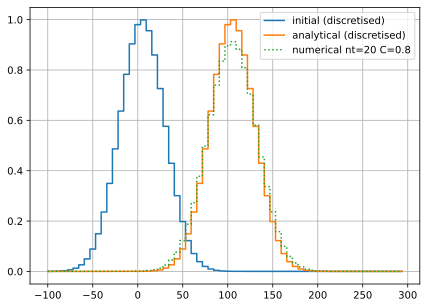

In [8]:
fig = pyplot.figure(figsize=(7,5))

pyplot.step(x, psi_0(x), label='initial (discretised)', where='mid')
pyplot.step(x, psi_0(x-u*t_max), label='analytical (discretised)', where='mid')
pyplot.step(x, psi, label=f'numerical {nt=} {C=}', where='mid', linestyle=':')
pyplot.legend()
pyplot.grid()
show_plot(fig=fig)

# Convergence analysis of the upwind scheme
The goal of convergence analysis is to evaluate how the numerical solution of a problem approaches the exact (analytical) solution as the discretization parameters (such as spatial step dx or temporal step dt
dt) are refined. This helps in verifying the correctness and accuracy of a numerical method and determining how fine the discretization needs to be to achieve a desired level of accuracy.

The analysis consists of creating a range of possible dx values and, for each value, calculating the Root Mean Squared Error (RMSE) between the numerical and analytical solutions. The Courant number C is kept constant to ensure fair comparison across different spatial resolutions.

For each dx, the number of spatial points nx is determined, and a spatial grid is created. The time step dt is computed maintaining the Courant condition. The number of time steps nt is derived from the max simulation time.

In [9]:
def calculate_RMSE(dx, C, u):
    
    nx = int(400 // dx) 
    i = slice(1, nx-2)
    x = np.linspace(-100, 300, nx, endpoint=False, retstep=False)
    dt = C * dx/u
    nt = int(t_max/dt)

    numerical = psi_0(x)
    for _ in range(nt):
        numerical[i] = numerical[i] - (F(numerical[i], numerical[i+one], C) - F(numerical[i-one], numerical[i], C))
    analitical = psi_0(x-u*t_max)
    return mean_squared_error(numerical, analitical)**(1/2)

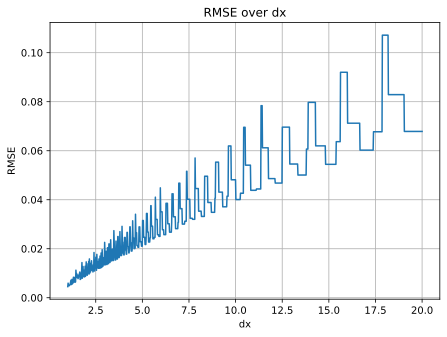

In [10]:
C_const = 0.8
dx_range = np.linspace(1, 20, 1000)
rmse_values = [calculate_RMSE(dx, C_const, u) for dx in dx_range]

fig = pyplot.figure(figsize=(7,5))
pyplot.plot(dx_range, rmse_values)
pyplot.xlabel("dx")
pyplot.ylabel("RMSE")
pyplot.title("RMSE over dx")
pyplot.grid()
pyplot.show()
show_plot(fig=fig)

The plot shows that reducing dx decreases RMSE, meaning finer spatial resolution improves accuracy. However, smaller dx also increases computational cost since the time step dt must also decrease.

At very small dx, accuracy gains become minimal, meaning further refinement is costly but not always beneficial. For large dx, the error increases and fluctuates, suggesting poor resolution or numerical instability.

Overall, the analysis helps find a balance between accuracy and computational efficiency.